# Boosting Homework 
***
**Name**: Saikrishna Jaliparthy
***

This assignment is due on Moodle by **5pm on Friday April 13th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***



In this homework you'll implement the AdaBoost classification framework to do handwritten digit recognition. Your implementation should be based on the description of AdaBoost given in the lecture slides.

<br>

![digits](mnist.png "mnist data")


<br>

Here are the rules: 

- Do **NOT** use sklearn's implementation of Adaboost.  You may however use sklearn's implementation of decisions trees. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

Since we'll be working with binary classifiers, we'll look at the subset of the MNIST data pertaining to handwritten three's and eights. Note that we'll also be using a lower-res version of the MNIST data used in the KNN homework. The class below will load, parse, and store the subset of the. Load the data and then report: 

- The number of examples in the training set 
- The number of examples in the validation set 
- The number of pixels in each image. 

In [2]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()

In [3]:
data = ThreesAndEights("../data/mnist21x21_3789.pklz")

In [187]:
print("The number of examples in the training set:",len(data.X_train))
print("The number of examples in the validation set:",len(data.X_valid))
print("The number of pixels in each image",len(data.X_train[0]))

The number of examples in the training set: 2000
The number of examples in the validation set: 500
The number of pixels in each image 441


### [20 points] Problem 2: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted shallow decision trees as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [244]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 
        
        
        length=len(y_train)
        w=np.ones(length)
        w.fill(1/length)
        #h = clone(self.base)
        #train_o=[np.zeros(len(X_train))]
        for k in range((self.n_learners)):
            h = clone(self.base)
            p=0
            h.fit(X_train, y_train, sample_weight=w)
            train_o=h.predict(X_train)
            for x1 in range(len(train_o)):
                if y_train[x1]!=train_o[x1]:
                    p+=w[x1]
            err_k=p / sum(w)
            
            self.alpha[k]=0.5*np.log((1-err_k)/(err_k))
            
            for i in range(len(w)):    
                mul=y_train[i]*train_o[i]
                w[i]=w[i]*np.exp(-1*self.alpha[k]*mul)
            self.learners.append(h)
            
            
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # TODO 

        pred=np.zeros(X.shape[0])
        for k in range((self.n_learners)):
            h=self.learners[k]
            x3=h.predict(X)
            y=x3 * self.alpha[k]
            pred+=y
        
        pred_a=1./(1+np.exp(-1*pred))
        pred_f=np.zeros(len(pred_a))
        
        for z in range(len(pred_a)):
            if pred_a[z]>0.5:
                pred_f[z]=1
            else:
                pred_f[z]=-1
            
        return pred_f

    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        # TODO 
        
        frompredict=self.predict(X)
        accuracy=0
        k=range(len(X))
        for j in k:
            if frompredict[j]==y[j]:
                accuracy+=1
        
        return accuracy/len(X)
            
        
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        # TODO 
        
        f=np.zeros((self.n_learners))
        pred=np.zeros(X.shape[0])
        acc=[]
        for k in range((self.n_learners)):
            h1=self.learners[k]
            x3=h1.predict(X)
            x4=x3 * self.alpha[k]
            pred+=x4
        
            pred_a=1./(1+np.exp(-1*pred))
            pred_f=np.zeros(len(pred_a))
        
            for z in range(len(pred_a)):
                if pred_a[z]>0.5:
                    pred_f[z]=1
                else:
                    pred_f[z]=-1
            
            wx=range(len(X))
            for qw in wx:
                if pred_f[qw]==y[qw]:
                    f[k]+=1
        
        acc=f/len(X)
        return acc

    
    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        
        
        # TODO
        
        margin=np.zeros(self.n_learners)
        alpha_normalize=self.alpha/sum(self.alpha)
        
        for nn in range(self.n_learners):
            meq=0
            mneq=0
            for lk in range(nn+1):
                hnn=self.learners[lk]
                tt=hnn.predict([x])
                
                if tt==y:
                    meq+=alpha_normalize[lk]
                else:
                    mneq+=alpha_normalize[lk]
            
            margin[nn]=meq-mneq
        
        return margin

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 


In [249]:
%run -i tests.py "part A"

test_alphas (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 

In [250]:
%run -i tests.py "part B"

test_prediction (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


**Part C**: Next, implement the `score` method which takes in a matrix of examples ${\bf X}$ and their associated true labels ${\bf y}$, makes predictions, and returns the classification accuracy.   

When you think you're done, run the following unit tests. 

In [251]:
%run -i tests.py "part C"

test_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


**Part D**: Finally, implement the `staged_score` method to return an array of prediction accuracies after each iteration of the AdaBoost algorithm.  That is, the staged score array ${\bf s}$ is defined such that ${\bf s}_\ell$ is the prediction accuracy using only the first $\ell$ weak learners.  This function is primarily used as a diagnostic tool for analyzing the performance of your classifier during the training process.  

**Note**: This method can be implemented in a very efficient or very **in**efficient matter.  Be sure to think about this a bit before diving in. 


When you think you're done, run the following unit tests. 

In [248]:
%run -i tests.py "part D"

test_staged_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


### [10 points] Problem 3: AdaBoost for Handwritten Digit Recognition 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration (on the same set of axes). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

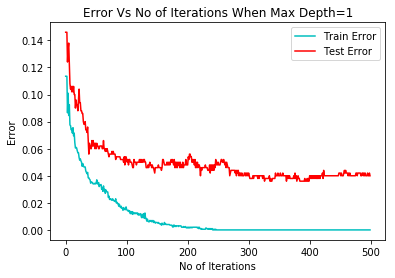

In [221]:
ad=AdaBoost(n_learners=500,base=DecisionTreeClassifier(max_depth=1),random_state=1234)
ad.fit(data.X_train,data.y_train)
tr_err1=ad.staged_score(data.X_train,data.y_train)
te_err1=ad.staged_score(data.X_valid,data.y_valid)

plt.plot(np.arange(500),1-tr_err1,'c',label='Train Error')
plt.plot(np.arange(500),1-te_err1,'r',label='Test Error')
plt.legend()
plt.title("Error Vs No of Iterations When Max Depth=1")
plt.xlabel('No of Iterations')
plt.ylabel('Error')
plt.show()

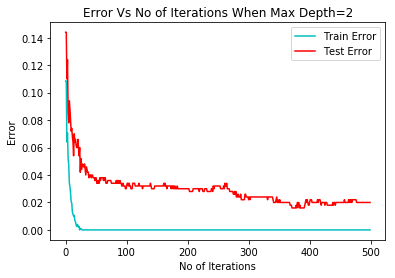

In [223]:
ad=AdaBoost(n_learners=500,base=DecisionTreeClassifier(max_depth=2),random_state=1234)
ad.fit(data.X_train,data.y_train)
tr_err2=ad.staged_score(data.X_train,data.y_train)
te_err2=ad.staged_score(data.X_valid,data.y_valid)

plt.plot(np.arange(500),1-tr_err2,'c',label='Train Error')
plt.plot(np.arange(500),1-te_err2,'r',label='Test Error')
plt.legend()
plt.title("Error Vs No of Iterations When Max Depth=2")
plt.xlabel('No of Iterations')
plt.ylabel('Error')
plt.show()

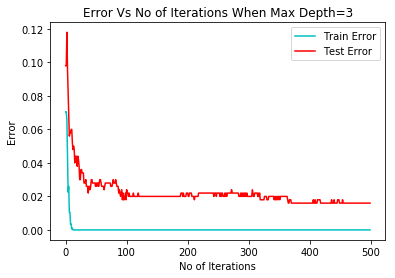

In [224]:
ad=AdaBoost(n_learners=500,base=DecisionTreeClassifier(max_depth=3),random_state=1234)
ad.fit(data.X_train,data.y_train)
tr_err3=ad.staged_score(data.X_train,data.y_train)
te_err3=ad.staged_score(data.X_valid,data.y_valid)

plt.plot(np.arange(500),1-tr_err3,'c',label='Train Error')
plt.plot(np.arange(500),1-te_err3,'r',label='Test Error')
plt.legend()
plt.title("Error Vs No of Iterations When Max Depth=3")
plt.xlabel('No of Iterations')
plt.ylabel('Error')
plt.show()

When we compared the three graphs of error vs number of iterations for different depths. When we consider the graph with max depth 1 training error decreases continously until iteration 200 and starts saturation to nearly zero from iteration 200 and after that from iteration 300 it's more or less become constant. when we consider the validation error was about from 0.04 to 0.06 at from iterations 100 to 500 before the iteration 100 validation error was continously decreasing..

When we compared the three graphs of error vs number of iterations for different depths. When we consider the graph with max depth 2 training error decreases contiously until iteration 20 and starts saturation to nearly zero from iteration 20 and after that it more or less become constant after that. when we consider the validation error was about from 0.02 to 0.04 at from iterations 50 to 500 before the iteration 50 validation error was continously decreasing.

When we compared the three graphs of error vs number of iterations for different depths. When we consider the graph with max depth 3 training error decreases contiously until iteration 10 and starts saturation to nearly zero from iteration 10 and after that it more or less become constant after that. when we consider the validation error was about from 0.02 to 0.03 at from iterations 50 to 500 before the iteration 50 validation error was continously decreasing.

So, when we consider the total three graphs. The graph with max depth 3 works best when we consider the training error and testing error as the number of iterations increases.

I don't see any signs of overfiiting in the graphs because when we consider the difference of error rates between training and validation error is very minute i.e in max depth 1 the error differnece is about 0.04, at max-depth 2 the error differnce is about 0.03 and at max-depth 3 the error difference is about the 0.02.

The classifier with the max depth 3 achieve 100% of training accuracy start from early iterations(i.e 10) and the accuracy on validation error has some sort of small up's and downs but the error is about 0.02.
The classifier with the max depth 2 achieve 100% of training accuracy start from early iterations(i.e 20) and the validation error decreases from 0.04 to 0.02 with little jitters in the variation.
The classifier with the max depth 1 achieve 100% of training accuracy start from iterations(i.e 250) and the validation error for further iterations is vary between 0.06 to 0.05 with some frequent ups and downs

### [15 points] Problem 4: AdaBoost as a Margin-Maximizing Model 
***

Despite the fact that we're making our model more complex with the addition of each weak learner, AdaBoost does not typically overfit the training data. The reason for this is that the model becomes more _confident_ with each boosting iteration. This _confidence_ can be interpreted mathematically as a margin. Recall that after $K$ iterations the algorithm terminates with the classifier 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

Similarly, we can define the intermediate classifier $H_\ell$ by 

$$
H_\ell({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^\ell\alpha_k h_k({\bf x}) \right]
$$

where $\ell \leq K$. Note that in either case the model returns predictions of the form $y \in \{-1, 1\}$ which does not give us any indication of the model's confidence in a prediction. Define the normalized coefficients $\hat{\alpha}_k$ as follows: 

$$
\hat{\alpha}_k = \dfrac{\alpha_k}{\sum_{t=1}^K \alpha_k}
$$

Define the margin of a training example ${\bf x}$ after $\ell$ iterations as the sum of the normalized coefficients of weak learners that vote correctly minus the sum of the normalized coefficients of the weak learners that vote incorrectly: 

$$
\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k 
$$

**Part A**: Briefly explain mathematically how $\textrm{margin}_\ell({\bf x})$ can be interpreted as a margin.  **Hint**: You'll want to think back on what we meant by a _margin_ in our discussion of Support Vector Machines. 

**Answer**

When we look over the margin equation above we can say that it is depend on the alpha normalize value which will again depend on the alpha values. So when the $h_k({\bf x}) = y$ it means that the it is classifiying correctly opposite is it is classifying wrongly. So more the classifying correctly more will the margin value and more will the confidence and more will be the alpha normlaize values.

So with high confidence the ($\textrm{margin}_\ell({\bf x})$) will be more typically greater than 0 (When we consider the svm sense more margin and high confidence is the point is classified correctly and the distance between decision boundary and the point is more).

With less confidence ($\textrm{margin}_\ell({\bf x})$) can be nearly around 0. Here the data will be classified correctly with less confidence. (In SVM Sense the distance between the point and decison boundary is less) 

If the margin ($\textrm{margin}_\ell({\bf x})$) becomes negative means the given data is wrongly classified (In SVM sense the point is farther away and it is incorretly classified).


**Part B**: Complete the `staged_margin` method in the `AdaBoost` class above so that it computes the margin for a single training example ${\bf x}$ after each boosting iteration. 

In [233]:
ad=AdaBoost(n_learners=200, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
ad.fit(data.X_train,data.y_train)
margin_value=ad.staged_margin(data.X_train[0],data.y_train[0])
#print(len(margin_value))
#print(margin_value)

**Part C**: Find four **training** examples from the MNIST that meet the following criteria: 

- one $3$ that AdaBoost can classify easily  
- one $8$ that AdaBoost can classify easily  
- one $3$ that AdaBoost has difficulty with 
- one $8$ that AdaBoost has difficulty with 

Use the `view_digit` function given below to display the four examples that you found. 

**Advice**: Since AdaBoost will likely classify **all** training examples correctly given enough boosting iterations, you might try fitting an AdaBoost classifier with just a handful of boosting iterations and use it to identify examples of each desired type. 

true label: -1


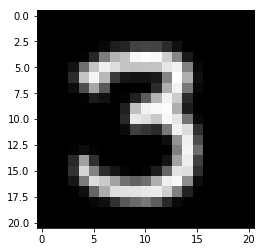

In [138]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(21,21), cmap='gray');
view_digit(data.X_train[0,:], data.y_train[0])

In [208]:
eightclassify=[] 
threeclassify=[]

for itr in range(len(data.y_train)):
    if data.y_train[itr]==1:
        margineight=ad.staged_margin(data.X_train[itr],data.y_train[itr])[-1]
        eightclassify.append((margineight,itr))
    else:
        marginthree=ad.staged_margin(data.X_train[itr],data.y_train[itr])[-1]
        threeclassify.append((marginthree,itr))
        
eightclassify=sorted(eightclassify, key=lambda x: x[0])
threeclassify=sorted(threeclassify, key=lambda y: y[0])

print("Three classify easily: ",threeclassify[-1])
print("Eight classify easily: ",eightclassify[-1])
print("Three difficulty with: ",threeclassify[0])
print("Eight difficulty with: ",eightclassify[0])


Three classify easily:  (0.45425851914617116, 678)
Eight classify easily:  (0.35109654062757545, 342)
Three difficulty with:  (-0.01390363992477156, 699)
Eight difficulty with:  (-0.004716887553258997, 194)


Three classify easily: 
true label: -1


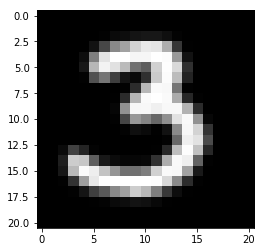

In [234]:
print("Three classify easily: ")
view_digit(data.X_train[678,:], data.y_train[678])

Eight classify easily: 
true label: 1


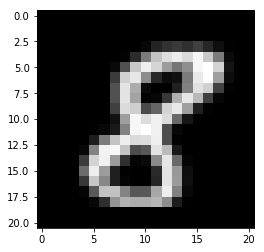

In [235]:
print("Eight classify easily: ")
view_digit(data.X_train[342,:], data.y_train[342])

Three difficulty with: 
true label: -1


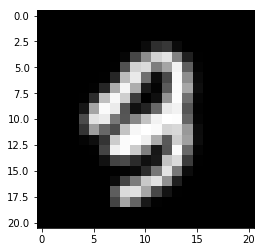

In [236]:
print("Three difficulty with: ")
view_digit(data.X_train[699,:], data.y_train[699])

Eight difficulty with: 
true label: 1


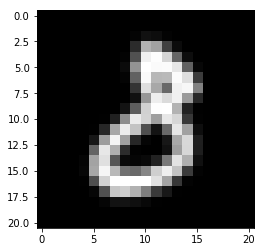

In [237]:
print("Eight difficulty with: ")
view_digit(data.X_train[194,:], data.y_train[194])

**Part D**: Using an AdaBoost classifier with at least $K=200$ depth-1 decision trees as the weak learners, plot the staged margin for each of the four examples that you found in **Part C** on the same set of axes. (Be sure to include a legend so we can tell which staged margin corresponds to which example).  Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.  


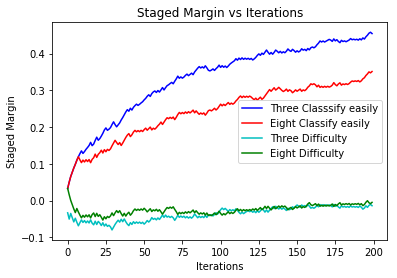

In [238]:
tec=ad.staged_margin(data.X_train[678],data.y_train[678])
ecc=ad.staged_margin(data.X_train[342],data.y_train[342])
tdc=ad.staged_margin(data.X_train[699],data.y_train[699])
edc=ad.staged_margin(data.X_train[194],data.y_train[194])


plt.plot(np.arange(200),tec,'b',label='Three Classsify easily')
plt.plot(np.arange(200),ecc,'r',label='Eight Classify easily')
plt.plot(np.arange(200),tdc,'c',label='Three Difficulty')
plt.plot(np.arange(200),edc,'g',label='Eight Difficulty')
plt.xlabel("Iterations")
plt.ylabel("Staged Margin")
plt.title("Staged Margin vs Iterations")
plt.legend()
plt.show()

When we consider the above graph of Staged margin vs Iterations when we consider the three classify easily graph the staged margin increases from 0.1 and when we consider the eight classify easily graph the staged margin increases from 0.12 but the rate in which it increases was less when we conider the three classify easily graph

When we consider the above graph of Staged margin vs iterations When we consider the three difficulty graph start from neagtive side about from -0.03 then it little bit decreases and then it starts increasing. When we consider the eight difficulty graph it starts from positiev and then starts decreaisng and nearly at 200 iterations the staged margin is neagtive which is nearly to zero. When we observe the change in the both three difficulty and eight difficulty graphs it is nearly same.

When we get the positive margin it means that all the training examples are classifying correctly so the training error become zero. So, even when the training error becomes zero the adaboost will continue to evolve by continously it will try to do with the same base learners. So as even training error becomes zero adaboost continues to evolve by improving generalization.So we can conclude that by margin maximizing property adaboost will continue to improve the generalization even after the error on the training set reaches zero.